Блокнот для обучения моделей классификации изображений в реальном времени с помощью PyTorch  
Использованы следующие материалы:  
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
Подробнее (Details) - https://habr.com/ru/post/478208/

Загрузим необходимые библиотеки

In [1]:
#Download the required libraries
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.onnx
import torchvision

%matplotlib inline

plt.ion()   # interactive moden

**Simple model**

Получим набор данных для модели.
Набор данных содержит папки trein и test, в которых размещены обучающие и контрольные изображения для наших двух классов (контроллер и малина).

In [2]:
#get address such as C:\\(folder with you notebook)
dir = os.path.abspath(os.curdir)
# i suppose what your image folders placed in datasets directory 
data_dir=os.path.join(dir, "datasets\\")

# Data scaled and normalization for training and testing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms ):


    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes




In [3]:
# get train and test data
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir,data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")

Classes:  ['raspberry', 'someduino']
The datasest have:  {'train': 256, 'test': 56}  images


Посмотрим, как выглядят наши обучающие изображения

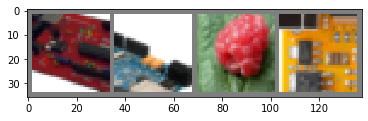

someduino someduino raspberry someduino


In [4]:
# create function for print unnormalized images
def imshow(img):
    img = img / 2+0.5      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cpu")

In [7]:
for epoch in range(11):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 15 == 14:    # print every 15 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 15))
            running_loss = 0.0

print('Finished Training')

[1,    15] loss: 0.691
[1,    30] loss: 0.689
[1,    45] loss: 0.697
[1,    60] loss: 0.689
[2,    15] loss: 0.681
[2,    30] loss: 0.679
[2,    45] loss: 0.665
[2,    60] loss: 0.670
[3,    15] loss: 0.619
[3,    30] loss: 0.614
[3,    45] loss: 0.577
[3,    60] loss: 0.579
[4,    15] loss: 0.524
[4,    30] loss: 0.503
[4,    45] loss: 0.361
[4,    60] loss: 0.510
[5,    15] loss: 0.446
[5,    30] loss: 0.437
[5,    45] loss: 0.363
[5,    60] loss: 0.330
[6,    15] loss: 0.430
[6,    30] loss: 0.435
[6,    45] loss: 0.345
[6,    60] loss: 0.313
[7,    15] loss: 0.453
[7,    30] loss: 0.317
[7,    45] loss: 0.258
[7,    60] loss: 0.334
[8,    15] loss: 0.352
[8,    30] loss: 0.362
[8,    45] loss: 0.281
[8,    60] loss: 0.347
[9,    15] loss: 0.254
[9,    30] loss: 0.163
[9,    45] loss: 0.284
[9,    60] loss: 0.455
[10,    15] loss: 0.309
[10,    30] loss: 0.352
[10,    45] loss: 0.219
[10,    60] loss: 0.248
[11,    15] loss: 0.269
[11,    30] loss: 0.139
[11,    45] loss: 0.218
[11,

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9698,  1.0581])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8926,  0.9614])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.5091, -0.5202])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.9285, -0.9257])


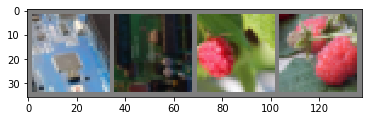

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9819,  1.0731])
Predict class - someduino, real class - raspberry, probability (raspberry,someduino) - tensor([-0.4369,  0.4554])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.6480, -1.6722])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9031,  0.9773])


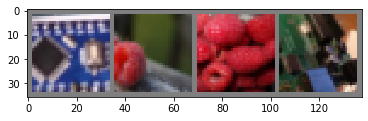

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.1206, -0.1068])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9192,  0.9938])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9132,  0.9824])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.3793, -2.3943])


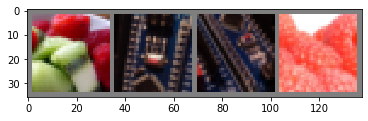

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.3806, -2.4130])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8981,  0.9658])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.1567, -2.1727])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.3180, -1.3256])


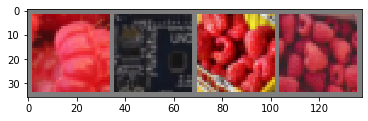

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8866,  0.9540])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9449,  1.0159])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.7546, -1.7745])
Predict class - raspberry, real class - someduino, probability (raspberry,someduino) - tensor([ 0.4462, -0.4285])


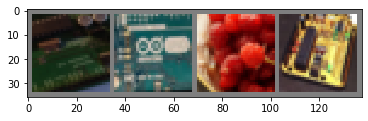

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.0978, -2.1533])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8886,  0.9558])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9481,  1.0229])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9110,  0.9788])


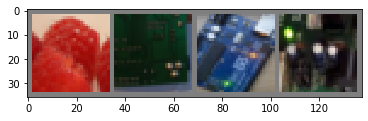

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.7144, -1.7582])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9778,  1.0523])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8904,  0.9578])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.8676, -1.8859])


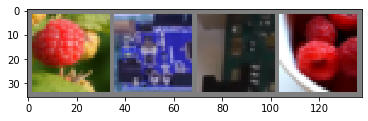

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8935,  0.9652])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.4659, -1.4854])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.5515, -0.5650])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.9409, -1.9872])


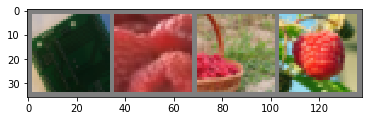

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.9853, -2.0059])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.2700, -1.2866])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9559,  1.0308])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.6234,  0.6636])


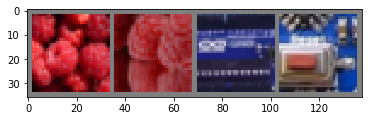

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.1384, -1.1000])
Predict class - raspberry, real class - someduino, probability (raspberry,someduino) - tensor([ 1.0223, -1.0081])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9142,  0.9839])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.1199, -0.1146])


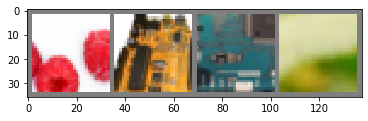

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9169,  0.9938])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.1100, -2.1303])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.0391, -1.0321])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9477,  1.0215])


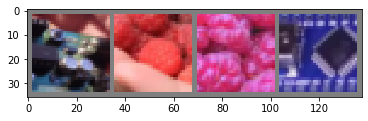

Predict class - someduino, real class - raspberry, probability (raspberry,someduino) - tensor([-0.7198,  0.7568])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.5660, -0.5430])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.2518, -0.2341])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9553,  1.0439])


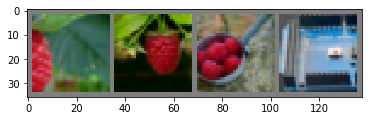

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9433,  1.0153])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8988,  0.9657])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.2265, -0.1708])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8826,  0.9607])


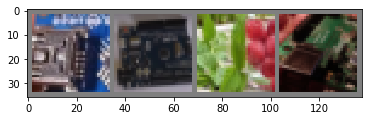

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9205,  0.9914])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.1256, -0.1288])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9962,  1.0808])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.9201, -1.9489])


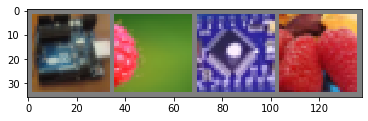

Accuracy of the network on the 56 test images: 92 %


In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        imshow(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (
    100 * correct / total))

*(Опционально) сохраним и восстановим нашу модель, а затем убедимся, что она также хорошо распознает изображения*

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.5995,  0.6728])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.4962, -1.4851])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.3181, -2.3492])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.1522, -1.1364])


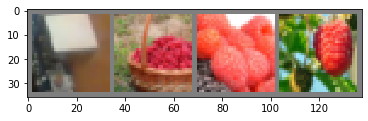

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.9979, -1.0179])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-1.0169,  1.1133])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.0182, -0.9829])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9079,  0.9926])


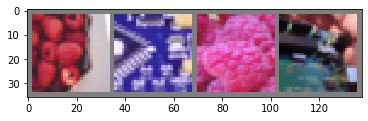

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9036,  0.9730])
Predict class - raspberry, real class - someduino, probability (raspberry,someduino) - tensor([ 0.4267, -0.4060])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8806,  0.9477])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8869,  0.9540])


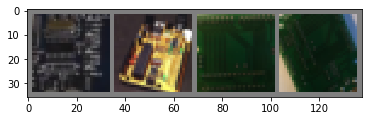

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.2387, -2.2727])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.8424, -1.8171])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8995,  0.9706])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.3593, -1.3935])


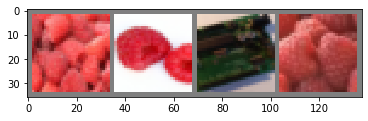

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.7821, -0.8104])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.7684, -1.7691])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.1261, -0.1309])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.9876, -2.0304])


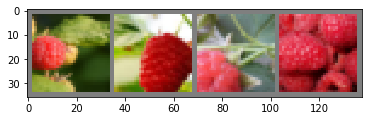

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8967,  0.9648])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9692,  1.0573])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9103,  0.9843])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9498,  1.0251])


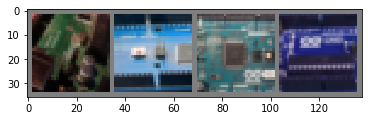

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9113,  0.9800])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9466,  1.0174])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9721,  1.0526])
Predict class - someduino, real class - raspberry, probability (raspberry,someduino) - tensor([-0.6941,  0.7888])


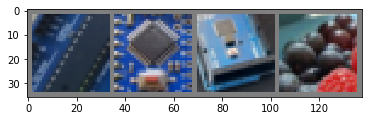

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9553,  1.0334])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9890,  1.0753])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9104,  0.9782])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9714,  1.0561])


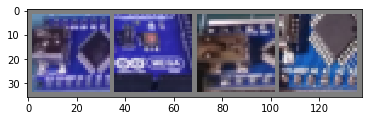

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9355,  1.0030])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.8244, -1.8778])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.5629, -0.5357])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8867,  0.9535])


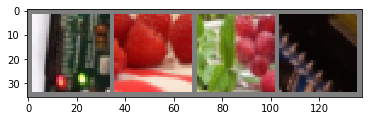

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.6709, -1.7234])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.1308, -1.1449])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.9036, -0.9593])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.7408, -0.8070])


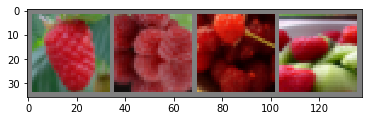

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.1316, -2.1784])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9139,  0.9818])
Predict class - someduino, real class - raspberry, probability (raspberry,someduino) - tensor([-0.3626,  0.3968])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8771,  0.9609])


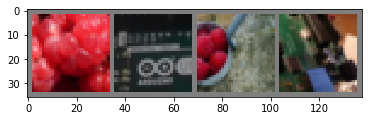

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.1166, -2.1389])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9163,  0.9868])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.2892, -0.3145])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.5658, -2.6354])


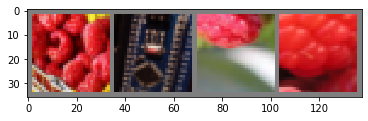

Predict class - raspberry, real class - someduino, probability (raspberry,someduino) - tensor([ 0.3770, -0.3293])
Predict class - someduino, real class - raspberry, probability (raspberry,someduino) - tensor([-0.8839,  0.9652])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8891,  0.9583])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.3504, -0.3589])


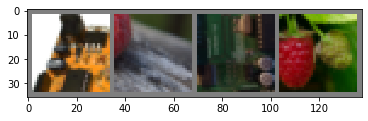

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.9419,  1.0245])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-0.8989,  0.9663])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.3098, -0.2906])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 0.5241, -0.5306])


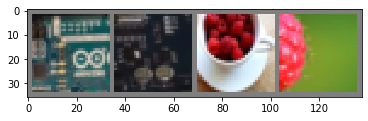

Accuracy of the network on the 56 test images: 91 %


In [9]:
#(Optional) 
#Save and load model
PATH =os.path.join(dir, "my_model.pth")
torch.save(net.state_dict(), PATH)

net = Net()
net.load_state_dict(torch.load(PATH))


#Test on cnages
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        imshow(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (
    100 * correct / total))

Сохраним нашу модель для использования в OpenCV

In [10]:
# Export model to onnx format
PATH =os.path.join(dir, "my_model.onnx")
dummy_input = Variable(torch.randn(1, 3, 32, 32))
torch.onnx.export(net, dummy_input, PATH)

**Transer Learning**

Используем готовую предварительно обученную и предварительно модель Renset18 и обучим ее на нашем наборе данных.

In [11]:
#Data scaled and normalization for training and testing for resnet18
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [12]:
# get train and test data
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir, data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")

Classes:  ['raspberry', 'someduino']
The datasest have:  {'train': 256, 'test': 56}  images


In [13]:
# Create new image show function for new transofration 
def imshow_resNet18(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

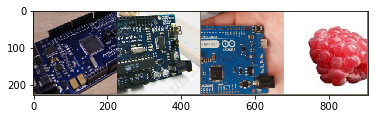

someduino someduino someduino raspberry


In [14]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images, labels = dataiter.next()

# show images
imshow_resNet18(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Создадим функцию обучения модели

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Подготовим параметры для обучения модели

In [16]:
# Let's prepare the parameters for training the model
dataloaders = {'train': trainloader, 'test': testloader}
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Обучим модель

In [17]:
#Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4445 Acc: 0.8125
test Loss: 0.0019 Acc: 1.0000

Epoch 1/4
----------
train Loss: 0.2874 Acc: 0.8945
test Loss: 0.0002 Acc: 1.0000

Epoch 2/4
----------
train Loss: 0.2507 Acc: 0.9141
test Loss: 0.0007 Acc: 1.0000

Epoch 3/4
----------
train Loss: 0.2774 Acc: 0.9141
test Loss: 0.0158 Acc: 1.0000

Epoch 4/4
----------
train Loss: 0.2714 Acc: 0.8984
test Loss: 0.0405 Acc: 0.9821

Training complete in 10m 24s
Best val Acc: 1.000000


Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 3.4114, -3.5259])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 3.9721, -5.2269])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 3.7269, -3.3142])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-4.3843,  2.7730])


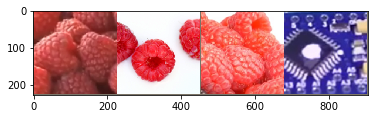

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.9569, -2.8973])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-5.4081,  4.7219])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.7142, -3.6009])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.9071, -3.4223])


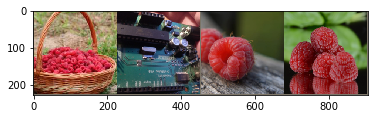

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-5.2089,  3.5855])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-6.4121,  4.3006])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-8.4731,  5.8392])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.1210, -2.1932])


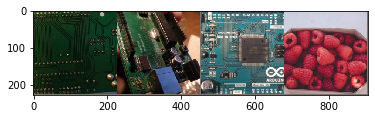

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.7755, -3.3498])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-8.7533,  7.0880])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-6.8066,  5.8456])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.9594, -3.3744])


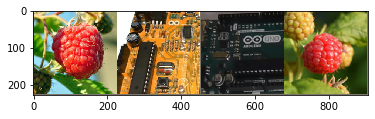

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-7.9839,  5.2994])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 3.0989, -3.3720])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-7.8058,  4.4497])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.7329, -3.6546])


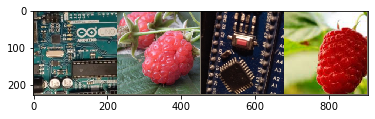

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-6.3365,  5.5903])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-4.0845,  3.6578])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-6.0083,  4.4775])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-6.8451,  5.2489])


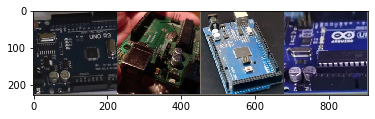

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 4.5569, -4.4141])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-6.7536,  4.3715])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-7.4627,  5.3812])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.9954, -2.8936])


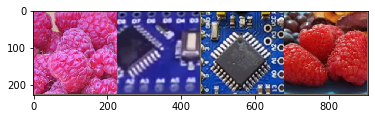

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-5.8278,  4.4753])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 3.2669, -3.6380])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-6.9609,  5.6591])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-5.8332,  5.5118])


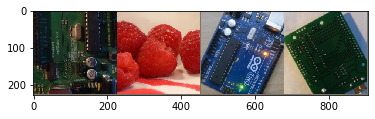

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 3.4278, -3.8318])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 4.1044, -4.6132])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 4.4601, -5.1992])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 4.3992, -5.1652])


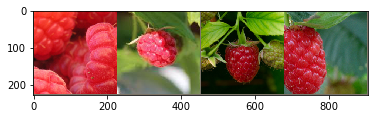

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-5.3425,  2.8839])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.8925, -3.6659])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-5.2897,  3.3318])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-7.8558,  5.2783])


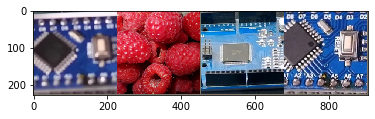

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-6.5890,  6.3581])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-5.1419,  4.2733])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.0320, -2.5687])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-5.4770,  4.3408])


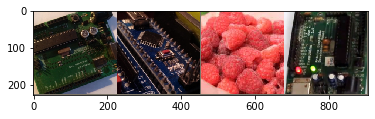

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 3.8167, -4.2360])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.5384, -2.7832])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.6487, -3.0070])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.9249, -3.6205])


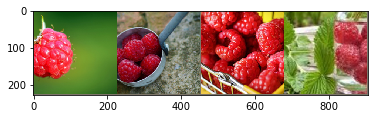

Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-6.1175,  5.2447])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.8493, -3.4561])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 2.0941, -4.1445])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-6.8238,  5.3054])


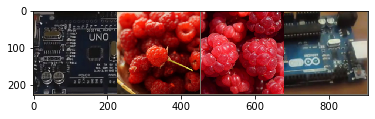

Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 3.5276, -4.9773])
Predict class - raspberry, real class - raspberry, probability (raspberry,someduino) - tensor([ 1.4981, -3.1363])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-7.0708,  5.4534])
Predict class - someduino, real class - someduino, probability (raspberry,someduino) - tensor([-4.9452,  3.5379])


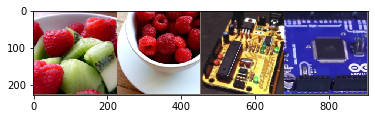

Accuracy of the network on the 56 test images: 100 %


In [18]:
# Visualization results of analysis test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        imshow_resNet18(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (
    100 * correct / total))

In [19]:
# Export model to onnx format
PATH =os.path.join(dir, "my_resnet18.onnx")
dummy_input = Variable(torch.randn(1, 3, 224, 224))
torch.onnx.export(model_ft, dummy_input, PATH)